In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import community.community_louvain as community
import seaborn as sns
from scipy import stats
from collections import defaultdict

df = pd.read_csv('Transmission_Lines.csv')

In [2]:
G = nx.Graph()

# Add edges from transmission lines
for _, row in df.iterrows():
    G.add_edge(row['from'], row['to'], 
               weight=row['length_km'],
               voltage=row['voltage_kv'])

# Basic network statistics
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 257
Number of edges: 284


# Degree Distribution

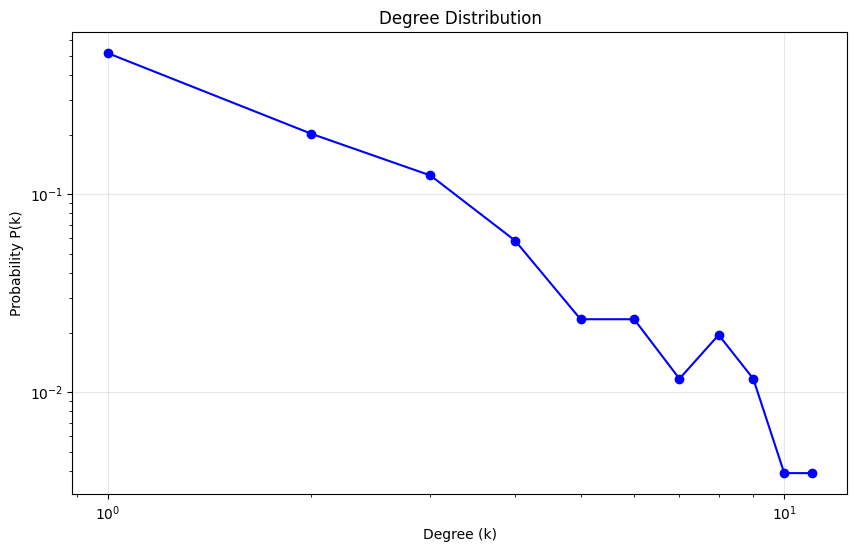

In [3]:
# 1. Degree Distribution P(k)
degrees = [d for n, d in G.degree()]
degree_count = Counter(degrees)
deg, cnt = zip(*sorted(degree_count.items()))

# Convert counts to probabilities by dividing by total number of nodes
total_nodes = G.number_of_nodes()
probabilities = [count/total_nodes for count in cnt]

plt.figure(figsize=(10, 6))
plt.plot(deg, probabilities, 'bo-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree (k)')
plt.ylabel('Probability P(k)')
plt.title('Degree Distribution')
plt.grid(True, alpha=0.3)

plt.show()

Power Law Exponent (γ): 2.05
R-squared: 0.942
P-value: 7.192e-07
Total nodes: 257


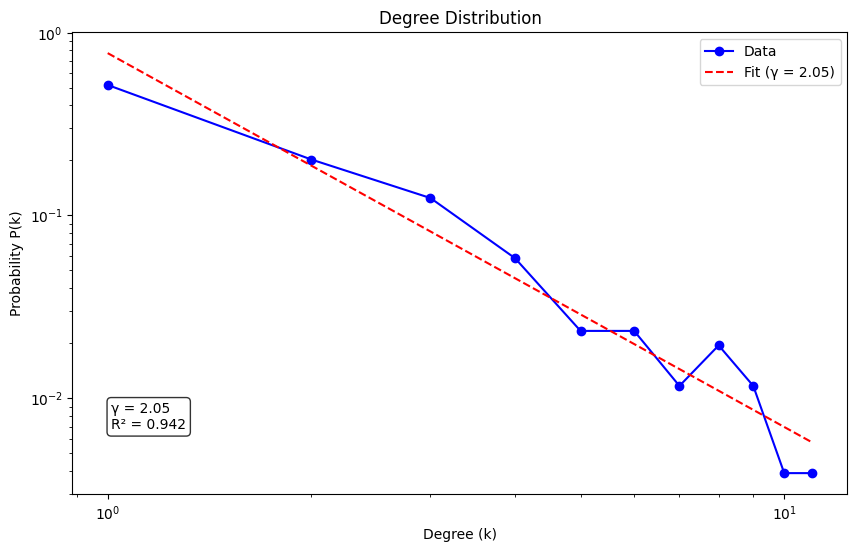

In [4]:
# Get degrees and count their frequency
degrees = [d for n, d in G.degree()]
degree_count = Counter(degrees)
deg, cnt = zip(*sorted(degree_count.items()))

# Convert counts to probabilities
total_nodes = G.number_of_nodes()
prob = [count/total_nodes for count in cnt]

# Convert to numpy arrays and take log
log_deg = np.log10(deg)
log_prob = np.log10(prob)

# Perform linear regression on log-log data
slope, intercept, r_value, p_value, std_err = stats.linregress(log_deg, log_prob)

# Print results
print(f"Power Law Exponent (γ): {-slope:.2f}")
print(f"R-squared: {r_value**2:.3f}")
print(f"P-value: {p_value:.3e}")
print(f"Total nodes: {total_nodes}")

# Create the plot
plt.figure(figsize=(10, 6))

# Plot actual data points
plt.plot(deg, prob, 'bo-', label='Data')

# Create and plot fitted line
x_fit = np.logspace(min(log_deg), max(log_deg), 100)
y_fit = 10**(slope * np.log10(x_fit) + intercept)
plt.plot(x_fit, y_fit, 'r--', label=f'Fit (γ = {-slope:.2f})')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree (k)')
plt.ylabel('Probability P(k)')
plt.title('Degree Distribution')
plt.legend()

# Add text box with fit statistics and total nodes
stats_text = f'γ = {-slope:.2f}\nR² = {r_value**2:.3f}'
plt.text(0.05, 0.2, stats_text, transform=plt.gca().transAxes,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.show()

In [5]:
# 3. Clustering Coefficient
# Global clustering coefficient
C = nx.average_clustering(G)
print(f"Global Clustering Coefficient: {C:.3f}")

Global Clustering Coefficient: 0.055


In [6]:
# Additional Network Metrics
print("\nAdditional Network Metrics:")
print(f"Network Density: {nx.density(G):.3f}")
# print(f"Network Diameter: {nx.diameter(G)}")
# print(f"Network Radius: {nx.radius(G)}")
print(f"Average Degree: {np.mean(degrees):.2f}")
print(f"Network Assortativity: {nx.degree_assortativity_coefficient(G):.3f}")


Additional Network Metrics:
Network Density: 0.009
Average Degree: 2.21
Network Assortativity: 0.009


# Connected Component

In [7]:
components = list(nx.connected_components(G))
num_components = len(components)

print(f"Number of connected components: {num_components}")
print("\nDetailed component analysis:")
print("-" * 50)

# Create a dictionary to store component details
component_details = defaultdict(list)

# Analyze each component
for idx, component in enumerate(components, 1):
    size = len(component)
    stations = sorted(list(component))  # Sort stations alphabetically
    
    print(f"\nComponent {idx}:")
    print(f"Size: {size} stations")
    print("Stations:")
    for station in stations:
        print(f"  - {station}")
    print("-" * 30)
    
    # Store details for DataFrame
    for station in stations:
        component_details['Component_ID'].append(idx)
        component_details['Station'].append(station)
        component_details['Component_Size'].append(size)

# Create a DataFrame with all component information
components_df = pd.DataFrame(component_details)

# Sort by Component_ID and Station name
components_df = components_df.sort_values(['Component_ID', 'Station'])

print("\nComponent Summary DataFrame:")
print(components_df)

Number of connected components: 24

Detailed component analysis:
--------------------------------------------------

Component 1:
Size: 208 stations
Stations:
  - AES Haripur
  - AKSML
  - Aftabnagar
  - Aminbazar
  - Amnura
  - Anowara
  - Ashuganj
  - Ashuganj (N)
  - Bagerhat
  - Baghabari
  - Bakulia
  - Banani
  - Bangabhaban
  - Bangladesh Border (Baharampur)
  - Bangladesh Border (Comilla)
  - Bangura
  - Banskhali
  - Barapukuria
  - Barguna PP
  - Barishal
  - Barishal (N)
  - Barmi (BR Powergen)
  - Baroaulia
  - Baroirhat
  - Bashundhara
  - Benapole
  - Bhaluka
  - Bhandaria
  - Bheramara
  - Bhola
  - Bhulta
  - Bibiyana
  - Bogura
  - Bogura (W)
  - Brahmanbaria
  - Cantonment
  - Chandpur
  - Chandraghona
  - Chapai Nawabganj
  - Char Saidpur
  - Chhatak
  - Chowmuhani
  - Chuadanga
  - Comilla (N)
  - Comilla (S)
  - Confidence PP
  - Cox's Bazar
  - Daudkandi
  - Daudkandi PP
  - Dhaka University (DU)
  - Dhamrai
  - Dhanmondi
  - Dohazari
  - Energaon
  - Faridpur
  -

# Robustness

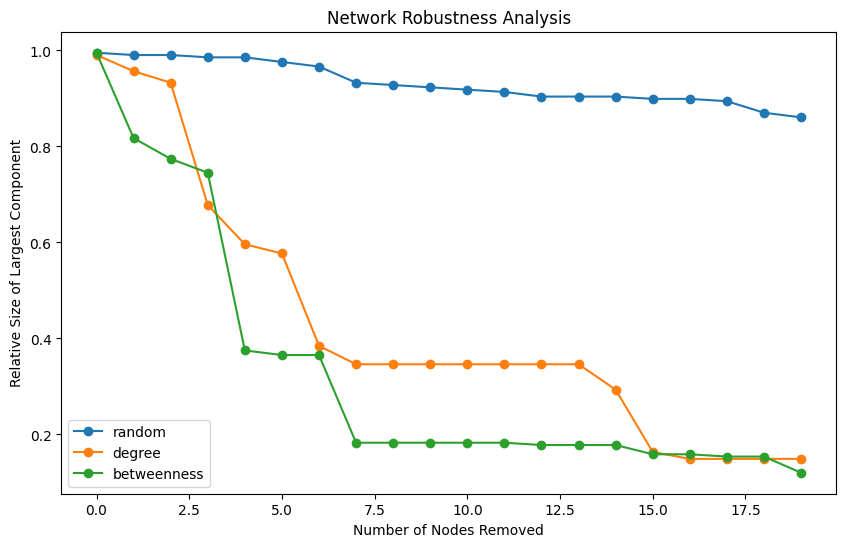

In [8]:
# Network Robustness Analysis
def network_robustness_analysis(G, n_removals=20):
    # Calculate initial largest component size
    initial_size = len(max(nx.connected_components(G), key=len))
    
    # Different attack strategies
    results = {
        'random': [],
        'degree': [],
        'betweenness': []
    }
    
    # Random failure
    G_random = G.copy()
    nodes_random = list(G_random.nodes())
    np.random.shuffle(nodes_random)
    
    # Targeted attack (highest degree first)
    G_degree = G.copy()
    nodes_degree = sorted(G_degree.degree(), key=lambda x: x[1], reverse=True)
    nodes_degree = [n[0] for n in nodes_degree]
    
    # Targeted attack (highest betweenness centrality first)
    G_between = G.copy()
    between_cent = nx.betweenness_centrality(G_between)
    nodes_between = sorted(between_cent.items(), key=lambda x: x[1], reverse=True)
    nodes_between = [n[0] for n in nodes_between]
    
    # Remove nodes and calculate largest component size
    for i in range(n_removals):
        # Random failure
        if nodes_random:
            G_random.remove_node(nodes_random[i])
            size = len(max(nx.connected_components(G_random), key=len))
            results['random'].append(size/initial_size)
            
        # Degree-based attack
        if nodes_degree:
            G_degree.remove_node(nodes_degree[i])
            size = len(max(nx.connected_components(G_degree), key=len))
            results['degree'].append(size/initial_size)
            
        # Betweenness-based attack
        if nodes_between:
            G_between.remove_node(nodes_between[i])
            size = len(max(nx.connected_components(G_between), key=len))
            results['betweenness'].append(size/initial_size)
    
    return results


# Perform robustness analysis
robustness_results = network_robustness_analysis(G)

# Plot robustness results
plt.figure(figsize=(10, 6))
for strategy, sizes in robustness_results.items():
    plt.plot(range(len(sizes)), sizes, '-o', label=strategy)
plt.xlabel('Number of Nodes Removed')
plt.ylabel('Relative Size of Largest Component')
plt.title('Network Robustness Analysis')
plt.legend()
# plt.grid(True)
plt.show()

In [9]:
def analyze_critical_nodes(G):
    """
    Analyze critical nodes and their missing neighbor connections in the largest component
    """
    # Get largest component
    largest_component = max(nx.connected_components(G), key=len)
    largest_subgraph = G.subgraph(largest_component).copy()
    
    # Find critical nodes
    betweenness = nx.betweenness_centrality(largest_subgraph)
    critical_nodes = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:3]
    
    print("Top 3 Critical Nodes Analysis:")
    print("-" * 50)
    
    for node, score in critical_nodes:
        print(f"\nNode: {node}")
        print(f"Betweenness Centrality: {score:.3f}")
        
        # Get neighbors and filter those with degree > 2
        neighbors = list(largest_subgraph.neighbors(node))
        neighbors = [n for n in neighbors if largest_subgraph.degree(n) > 2]
        print(f"Number of high-degree neighbors (degree > 2): {len(neighbors)}")
        print("High-degree neighbors:")
        for n in neighbors:
            print(f"{n}")
        
        if len(neighbors) >= 2:
            missing_connections = [
                (n1, n2) for i, n1 in enumerate(neighbors)
                for n2 in neighbors[i+1:]
                if not largest_subgraph.has_edge(n1, n2)
            ]
            
            if missing_connections:
                print("\nMissing connections between high-degree neighbors:")
                for n1, n2 in missing_connections:
                    print(f"  {n1} - {n2}")
            else:
                print("\nAll possible connections between high-degree neighbors exist")
        else:
            print("\nNot enough high-degree neighbors for additional connections")

# Run the analysis
analyze_critical_nodes(G)

Top 3 Critical Nodes Analysis:
--------------------------------------------------

Node: Meghnaghat
Betweenness Centrality: 0.299
Number of high-degree neighbors (degree > 2): 5
High-degree neighbors:
Aminbazar
Madunaghat
Haripur
Hasnabad
Comilla (N)

Missing connections between high-degree neighbors:
  Aminbazar - Madunaghat
  Aminbazar - Haripur
  Aminbazar - Comilla (N)
  Madunaghat - Haripur
  Madunaghat - Hasnabad
  Madunaghat - Comilla (N)
  Haripur - Hasnabad
  Haripur - Comilla (N)
  Hasnabad - Comilla (N)

Node: Comilla (N)
Betweenness Centrality: 0.287
Number of high-degree neighbors (degree > 2): 7
High-degree neighbors:
Meghnaghat
Ashuganj
Hathazari
Bibiyana
Feni
Daudkandi
Chandpur

Missing connections between high-degree neighbors:
  Meghnaghat - Ashuganj
  Meghnaghat - Hathazari
  Meghnaghat - Bibiyana
  Meghnaghat - Feni
  Meghnaghat - Daudkandi
  Meghnaghat - Chandpur
  Ashuganj - Hathazari
  Ashuganj - Bibiyana
  Ashuganj - Feni
  Ashuganj - Daudkandi
  Ashuganj - Chan

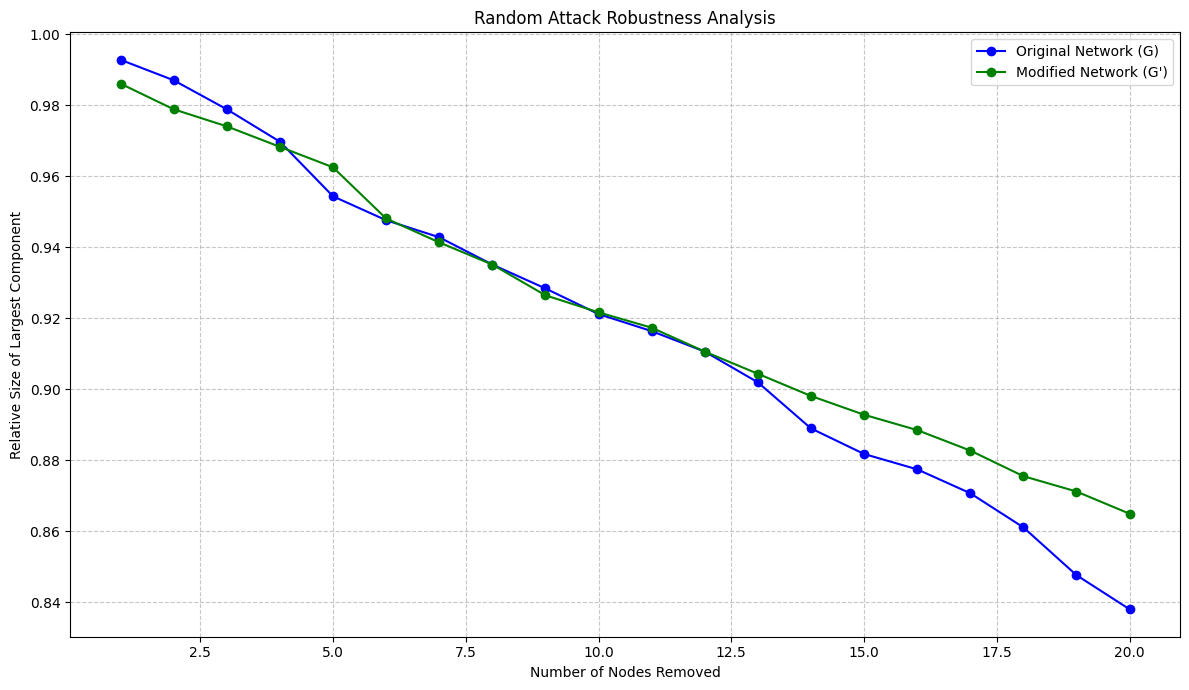

In [30]:
# result of increased robustness

np.random.seed(42)

G_prime = G.copy()

# Add new edges to G_prime
new_edges = [
    ('Meghnaghat', 'Ashuganj'),       # ~64 km
    ('Haripur', 'Comilla (N)'),       # ~80 km
    ('Comilla (N)', 'Ghorasal'),      # ~83 km
    ('Sirajganj', 'Brahmanbaria'),    # ~153 km
    ('Bibiyana', 'Chandpur'),         # ~156 km
    ('Aminbazar', 'Madunaghat')       # ~226 km
]

G_prime.add_edges_from(new_edges)



def random_attack_analysis(G, n_removals=20, n_simulations=10):
    initial_size = len(max(nx.connected_components(G), key=len))
    all_results = []
    
    for _ in range(n_simulations):
        G_temp = G.copy()
        nodes = list(G_temp.nodes())
        np.random.shuffle(nodes)
        results = []
        
        for i in range(n_removals):
            if nodes:
                # Remove node and calculate largest component size
                G_temp.remove_node(nodes[i])
                if G_temp.number_of_nodes() > 0:
                    size = len(max(nx.connected_components(G_temp), key=len))
                    results.append(size/initial_size)
                else:
                    results.append(0)
                    
        all_results.append(results)
    
    # Calculate average results across all simulations
    avg_results = np.mean(all_results, axis=0)
    std_results = np.std(all_results, axis=0)
    
    return avg_results, std_results

# Perform random attack analysis on both networks
avg_results_G, std_results_G = random_attack_analysis(G)
avg_results_G_prime, std_results_G_prime = random_attack_analysis(G_prime)


# Plot results
plt.figure(figsize=(12, 7))

# Plot original network results with error bands
x = range(1, len(avg_results_G) + 1)
plt.plot(x, avg_results_G, '-o', label='Original Network (G)', color='blue')


# Plot modified network results with error bands
plt.plot(x, avg_results_G_prime, '-o', label='Modified Network (G\')', color='green')


plt.xlabel('Number of Nodes Removed')
plt.ylabel('Relative Size of Largest Component')
plt.title('Random Attack Robustness Analysis')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()

# Centrality

In [10]:
# Centrality Measures
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)

print("\nTop 5 nodes by different centrality measures:")
print("\nDegree Centrality:")
for node, cent in sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"{node}: {cent:.3f}")

print("\nBetweenness Centrality:")
for node, cent in sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"{node}: {cent:.3f}")

print("\nCloseness Centrality:")
for node, cent in sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f"{node}: {cent:.3f}")


Top 5 nodes by different centrality measures:

Degree Centrality:
Haripur: 0.043
Madunaghat: 0.039
Aminbazar: 0.035
Comilla (N): 0.035
Rampura: 0.035

Betweenness Centrality:
Meghnaghat: 0.196
Comilla (N): 0.187
Ashuganj: 0.177
Aminbazar: 0.176
Ghorasal: 0.169

Closeness Centrality:
Meghnaghat: 0.200
Ghorasal: 0.196
Comilla (N): 0.195
Aminbazar: 0.192
Ashuganj: 0.191


# Community

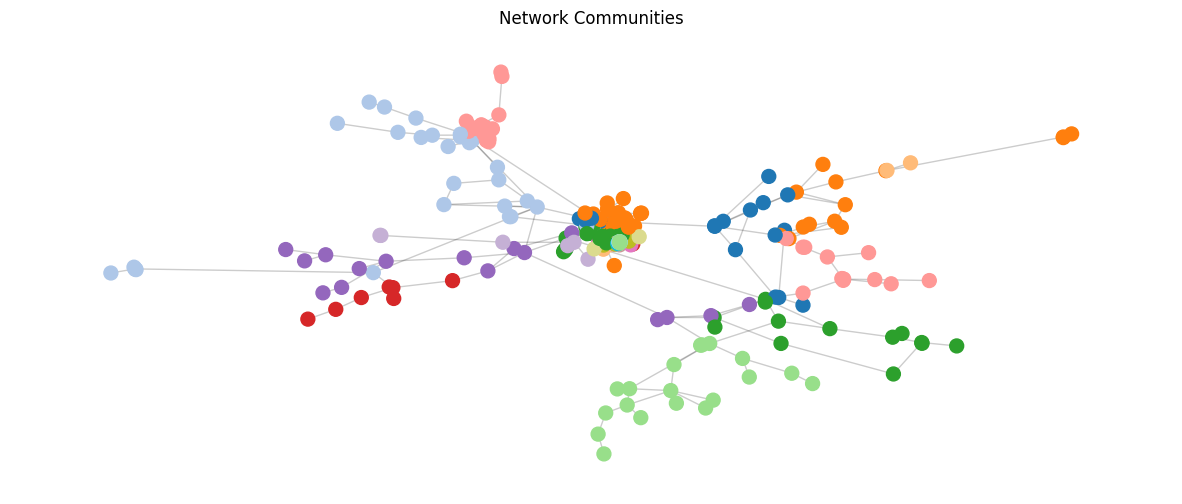

In [35]:
# 4. Community Detection and Visualization
# Detect communities
communities = community.best_partition(G)
nx.set_node_attributes(G, communities, 'community')

# Visualization with communities
plt.figure(figsize=(15, 6))
pos = nx.kamada_kawai_layout(G)  # Changed from spring_layout to kamada_kawai
nx.draw_networkx_nodes(G, pos, 
                      node_color=list(communities.values()),
                      node_size=100,
                      cmap=plt.cm.tab20)
nx.draw_networkx_edges(G, pos, alpha=0.2)
# nx.draw_networkx_labels(G, pos, font_size=8)  # Added labels
plt.title('Network Communities')
plt.axis('off')
plt.show()

In [36]:
# Print stations by community
community_groups = {}
for node, comm in communities.items():
    if comm not in community_groups:
        community_groups[comm] = []
    community_groups[comm].append(node)

# Print sorted by community number
print("\nStations by Community:")
print("----------------------")
for comm_id in sorted(community_groups.keys()):
    print(f"\nCommunity {comm_id}:")
    stations = sorted(community_groups[comm_id])  # Sort stations alphabetically
    for station in stations:
        print(f"- {station}")
    print(f"Total stations in community: {len(stations)}")


Stations by Community:
----------------------

Community 0:
- Bangladesh Border (Baharampur)
- HVDC Bheramara
- Khulna
Total stations in community: 3

Community 1:
- Aminbazar
- Barishal (N)
- Bheramara
- Cantonment
- Faridpur
- Gallamari
- Gopalganj
- Gopalganj PP
- LILO of Hasnabad
- Madaripur
- Modhumati PP
- Old Airport
- Rampal
- Satmasjid
- Savar
- Shariatpur
Total stations in community: 16

Community 2:
- Banskhali
- Chandraghona
- Kalurghat
- Khagrachari
- LILO of Matarbari
- Madunaghat
- Madunaght (O)
- Matarbari
- Meghnaghat
- Rangamati
- T-connection from Dohazari-Cox's Bazar
Total stations in community: 11

Community 3:
- Bangladesh Border (Comilla)
- Baroirhat
- Bibiyana
- Chandpur
- Chowmuhani
- Comilla (N)
- Comilla (S)
- Daudkandi
- Daudkandi PP
- Dhamrai
- Feni
- Hathazari
- Kaliakoir
- Kaptai
- LILO of Kabirpur-Tangail
- LILO of Sikalbaha
- LILO of Tongi
- Megnaghat Rental PP
- Raojan
- Sonargaon
- Uttara PP
Total stations in community: 21

Community 4:
- AES Haripur